(360, 960, 3)


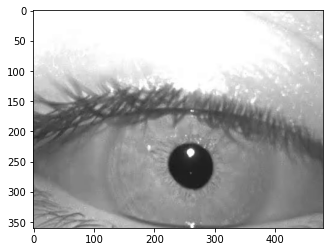

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
cap = cv2.VideoCapture("video1(1).mp4")
# checking the left frame 
while True:
    ret, frame = cap.read()
    roi = frame[:, 0: 480]
    print(frame.shape)
    break
plt.imshow(roi)

In [2]:
from scipy.spatial import distance as dist
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[3])
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[2])
    # compute the eye aspect ratio
    ear = A / C
    # return the eye aspect ratio
    return ear

In [3]:
import cv2
import numpy as np
import time
EYE_AR_THRESH=0.35
EYE_AR_CONSEC_FRAMES = 4
COUNTER1 = 0
TOTAL1 = 0
COUNTER2 = 0
TOTAL2 = 0
j=1
cap = cv2.VideoCapture("video1(1).mp4")


#Time cokmplexity - O(N)

while True:
    ret, frame = cap.read()
    if ret is False:
        break
    roi1 = frame[:, 0: 480]
    roi2 = frame[:, 480:]
    gray1 = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(roi2, cv2.COLOR_BGR2GRAY)
    gray_roi1 = cv2.GaussianBlur(gray1, (5, 5), 0)
    gray_roi2 = cv2.GaussianBlur(gray2, (5, 5), 0)
    #print(gray_roi1)
    #print(gray_roi2)
    _, threshold11 = cv2.threshold(gray_roi1, 140,255, cv2.THRESH_BINARY_INV) #eye is detcted at this point
    _, threshold12 = cv2.threshold(gray_roi1, 70, 255, cv2.THRESH_BINARY_INV)# pupil is detected at this point
    _, threshold21 = cv2.threshold(gray_roi2, 140, 255, cv2.THRESH_BINARY_INV)# eye is detected at this point
    _, threshold22 = cv2.threshold(gray_roi2, 70, 255, cv2.THRESH_BINARY_INV)# pupil is detected at this point

    
    contours11,_ = cv2.findContours(threshold11, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours12,_ = cv2.findContours(threshold12, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours21,_ = cv2.findContours(threshold21, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours22,_ = cv2.findContours(threshold22, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contours11 = sorted(contours11, key=lambda x: cv2.contourArea(x), reverse=True)
    contours12 = sorted(contours12, key=lambda x: cv2.contourArea(x), reverse=True)
    contours21 = sorted(contours21, key=lambda x: cv2.contourArea(x), reverse=True)
    contours22 = sorted(contours22, key=lambda x: cv2.contourArea(x), reverse=True)
    
    print(len(contours12[0]))
    try:
        (x, y, w, h) = cv2.boundingRect(contours11[0])
        cv2.rectangle(roi1, (x, y), (x + w, y + h), (255, 0, 0), 2)
        eyes_left=[(x,y+int(h/2)),(x + int(w/2),y),(x+w,y+int(h/2)),(x+int(w/2),y+h)]
        asp_left = eye_aspect_ratio(eyes_left)
        #print("left:",asp_left)
            

        eye_left=cv2.convexHull(contours12[0])
        cv2.drawContours(roi1, [eye_left], -1, (0, 255, 0), 1)
        
        
        (x, y, w, h) = cv2.boundingRect(contours21[0])
        cv2.rectangle(roi2, (x, y), (x + w, y + h), (255, 0, 0), 2)
        eyes_right=[(x,y+int(h/2)),(x + int(w/2),y),(x+w,y+int(h/2)),(x+int(w/2),y+h)]
        asp_right = eye_aspect_ratio(eyes_right)
        #print("right:",asp_right)
            
        eye_right=cv2.convexHull(contours22[0])
        cv2.drawContours(roi2, [eye_right], -1, (0, 255, 0), 1)
            
        
        if len(contours12[0])>250:
            cv2.putText(roi1, "Pupil not detected ", (10, 50),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            #print("left eye pupil not detected at:",str(cap.get(cv2.CAP_PROP_POS_MSEC)/1000)+" seconds")
        
        if len(contours22[0])>250:
            cv2.putText(roi2, "Pupil not detected ", (10, 50),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            #print("right eye pupil not detected at:"+str(cap.get(cv2.CAP_PROP_POS_MSEC)/1000)+" seconds")
        
        if asp_left < EYE_AR_THRESH:
            COUNTER1 += 1
            
        # otherwise, the eye aspect ratio is not below the blink
        # threshold
        else:
            # if the eyes were closed for a sufficient number of frames
            # then increment the total number of blinks
            if COUNTER1 >= EYE_AR_CONSEC_FRAMES:
                TOTAL1 += 1
            # reset the eye frame counter
            COUNTER1 = 0
        
        if asp_right < EYE_AR_THRESH:
            COUNTER2 += 1
        # otherwise, the eye aspect ratio is not below the blink
        # threshold
        else:
            # if the eyes were closed for a sufficient number of
            # then increment the total number of blinks
            if COUNTER2 >= EYE_AR_CONSEC_FRAMES:
                TOTAL2 += 1

            # reset the eye frame counter
            COUNTER2 = 0
        
        # draw the total number of blinks on the frame along with
        # the computed eye aspect ratio for the frame
        cv2.putText(roi1, "Blinks: {}".format(TOTAL1), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(roi1, "ASPECT RATIO: {:.2f}".format(asp_left), (250, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        cv2.putText(roi2, "Blinks: {}".format(TOTAL2), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(roi2, "ASPECT RATIO: {:.2f}".format(asp_right), (250, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    except Exception as e:
        print(e)
    #cv2.imshow("threshold", dilation12)
    #cv2.imshow("threshold", threshold12)
    #cv2.imshow("gray roi", gray_roi)
    #cv2.imshow("left", roi1)
    cv2.imshow("final", cv2.hconcat([roi1, roi2]))
    #cv2.imwrite("output/video1/"+str(j)+".jpg",cv2.hconcat([roi1, roi2]))
    j+=1
    key = cv2.waitKey(30)
    if key == 27:
        break
cv2.destroyAllWindows()

110
100
102
104
103
105
108
108
98
102
102
104
106
110
104
113
108
105
105
109
115
103
108
102
104
114
106
111
119
109
100
114
100
99
104
108
103
104
109
107
104
100
94
96
106
115
106
109
99
106
105
100
100
114
104
98
114
100
102
99
104
104
100
111
109
100
106
105
106
102
111
108
107
101
103
112
115
101
101
96
112
106
111
104
101
98
107
88
75
list index out of range
60
88
82
64
51
61
97
223
516
355
587
577
586
578
106
103
106
108
109
112
117
110
106
117
106
104
108
110
116
94
98
96
104
103
108
113
104
98
96
104
103
108
104
111
108
106
116
104
108
102
104
112
109
115
100
106
104
110
102
113
111
113
126
112
108
114
106
110
104
108
110
107
111
106
106
113
110
110
114
110
110
109
114
112
110
110
111
102
102
104
104
104
100
96
98
94
100
107
100
102
106
101
109
106
115
105
107
107
102
113
107
105
99
98
103
97
108
105
98
106
102
105
104
104
102
94
109
113
100
111
97
98
97
100
100
101
99
125
124
92
106
104
110
106
107
110
100
98
105
100
100
112
99
109
96
102
103
108
102
98
97
98
109
111
102
99

In [31]:
import os

os.system('ffmpeg -i output/video5/%d.jpg output/out5.mp4')

ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvo

0